In [2]:
from collections import defaultdict
import re
import pandas

In [18]:
evaluating = re.compile("Evaluating models_for_gan/cremmalab5\.?(?P<bw>nobw)?\.nfc-0\.(?P<score>\d+)\.mlmodel\s*")
test_file = re.compile("Testing ./test-microfilm-(?P<mss>\d+).txt (?P<mode>[\w\s]+)")
accuracy = re.compile("(?P<acc>[\d\.]+)%\s+Accuracy")
characters = re.compile("(?P<chr>\d+)\s+Characters")
errors = re.compile("(?P<chr>\d+)\s+Errors")

# TESTFILE:./prediction/htr/test-sets/colorized-125v-126r.xml.txt
# MODEL:./models/htr/cremmalabMICROFILM.nfc.noaugment_52_0.9321.mlmodel

testfile = re.compile(r"(colorized|microfilm)\-([0-9\-vr]+)\.xml")
model_match = re.compile(r"(?P<color>nobw\.)?nfc\.?(?P<augment>noaugment)"
                         r"?_(?P<epoch>\d+)_(?P<score>0\.\d+)\.mlmodel")

data = [
    ["Colorized", "Mode", "Augmented", "MSS", "Score", "Accuracy", 
     "Characters", "Errors", "SpacesErrors", "NonSpaceAccuracy"]
]

def register(*args):
    data.append(list(args))

    
with open("logs/test-htr.log") as f:
    score = None
    for line in f:
        line = line.strip()
        if line.startswith("TESTFILE:"):
            if score is not None:
                # New test files happen before Evaluating is called !
                register(colorized, mode, augment, mss, f"{epoch}-{score}", acc, chars, errs, spaces_error, (errs-spaces_error)/chars)
                # Set score to None to not triger evaluating register
                score = None
            color_info, mss = testfile.findall(line)[0]
            colorized = color_info == "colorized"
            spaces_error = 0
        elif line.startswith("MODEL:"):
            color, augment, epoch, score = model_match.findall(line)[0]
            mode = "nobw" if color == "nobw." else "bw"
            augment = False if augment == "noaugment" else True
        elif accuracy.match(line.strip()):
            acc = float(accuracy.findall(line.strip())[0])
        elif characters.match(line.strip()):
            chars = int(characters.findall(line.strip())[0])
        elif errors.match(line.strip()):
            errs = int(errors.findall(line.strip())[0])
        elif "SPACE" in line:
            spaces_error += int(line.split()[0])
            
register(colorized, mode, augment, mss, f"{epoch}-{score}", acc, chars, errs, spaces_error, (errs-spaces_error)/chars)
    
print(len(data)-1)

240


In [24]:
df = pandas.DataFrame(data[1:], columns=data[0])

df.to_csv("data.csv")

#df.groupby(by="Colorized").plot.hist(y="Accuracy")
df.groupby(by=["Colorized", "Mode"]).count() // 3

df.groupby(by=["Colorized", "Mode", "Score"]).count()

Augmented  MSS  Accuracy  Characters  Errors  \
Colorized Mode Score                                                      
False     bw   103-0.9447          3    3         3           3       3   
               104-0.9447          3    3         3           3       3   
               52-0.9321           3    3         3           3       3   
               55-0.9315           3    3         3           3       3   
               57-0.9318           3    3         3           3       3   
...                              ...  ...       ...         ...     ...   
True      nobw 92-0.9549           3    3         3           3       3   
               93-0.9549           3    3         3           3       3   
               96-0.954            3    3         3           3       3   
               97-0.9542           3    3         3           3       3   
               99-0.9537           3    3         3           3       3   

                           SpacesErrors  NonSpaceAccuracy  
Colorized Mode Score                                       
False     bw   103-0.9447             3                 3  
               104-0.9447             3                 3  
               52-0.9321              3                 3  
               55-0.9315              3                 3  
               57-0.9318              3                 3  
...                                 ...               ...  
True      nobw 92-0.9549              3                 3  
               93-0.9549              3                 3  
               96-0.954               3                 3  
               97-0.9542              3                 3  
               99-0.9537              3                 3  

[80 rows x 7 columns]

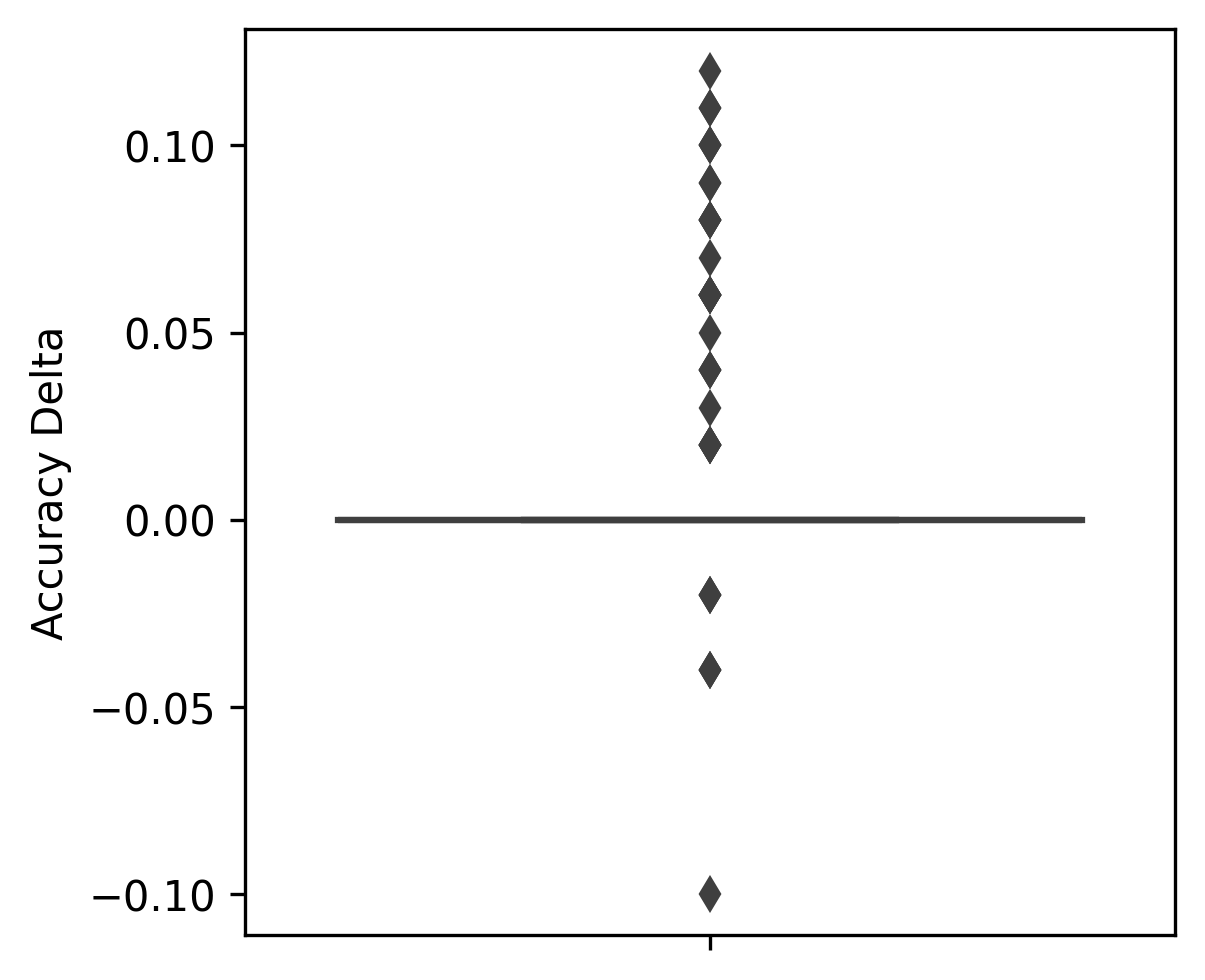

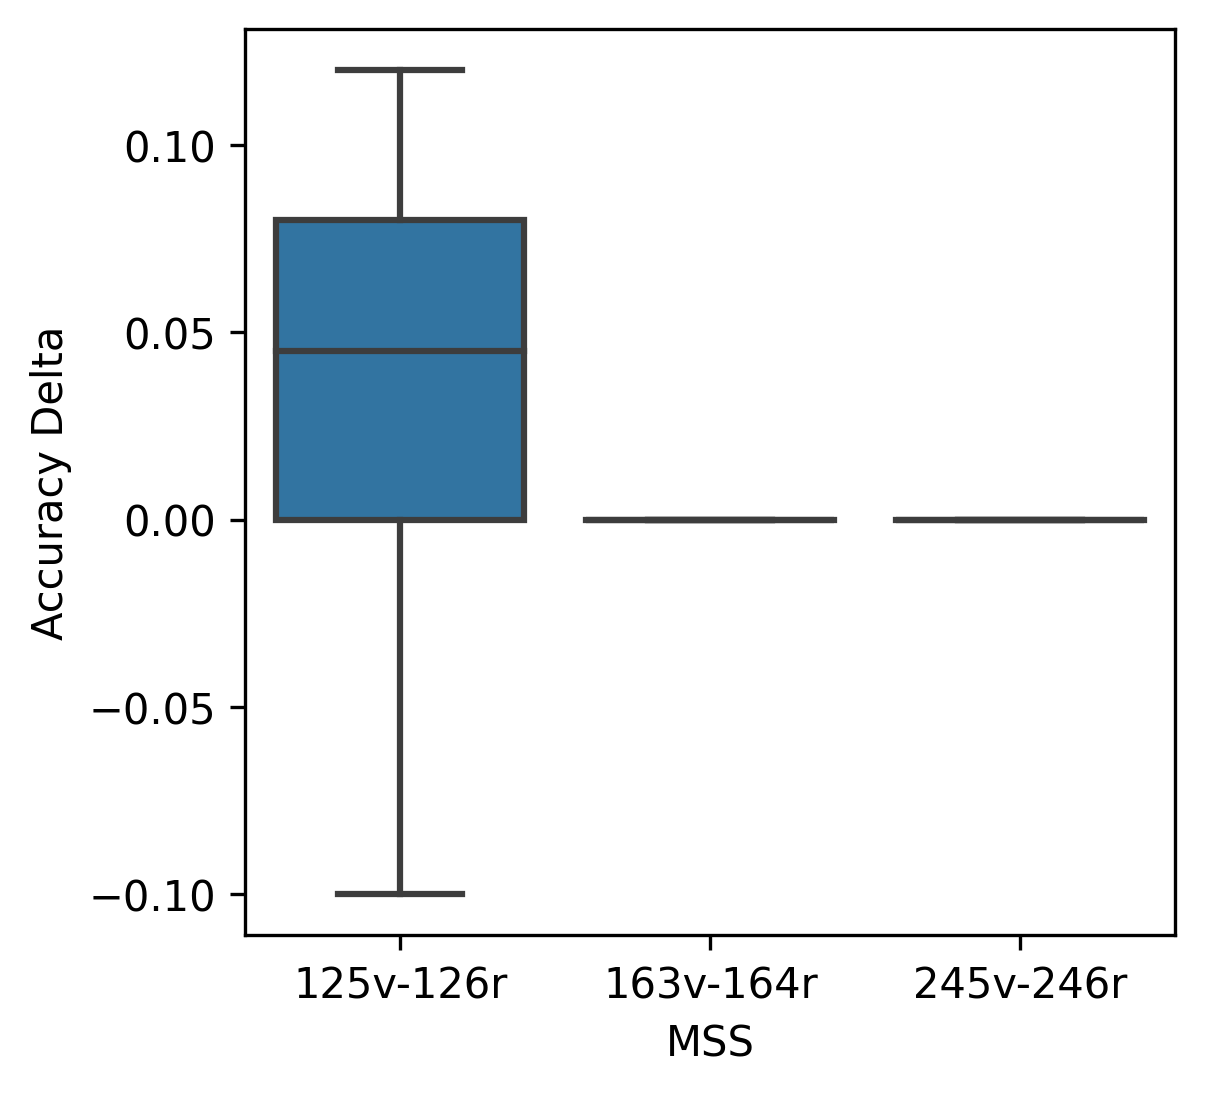

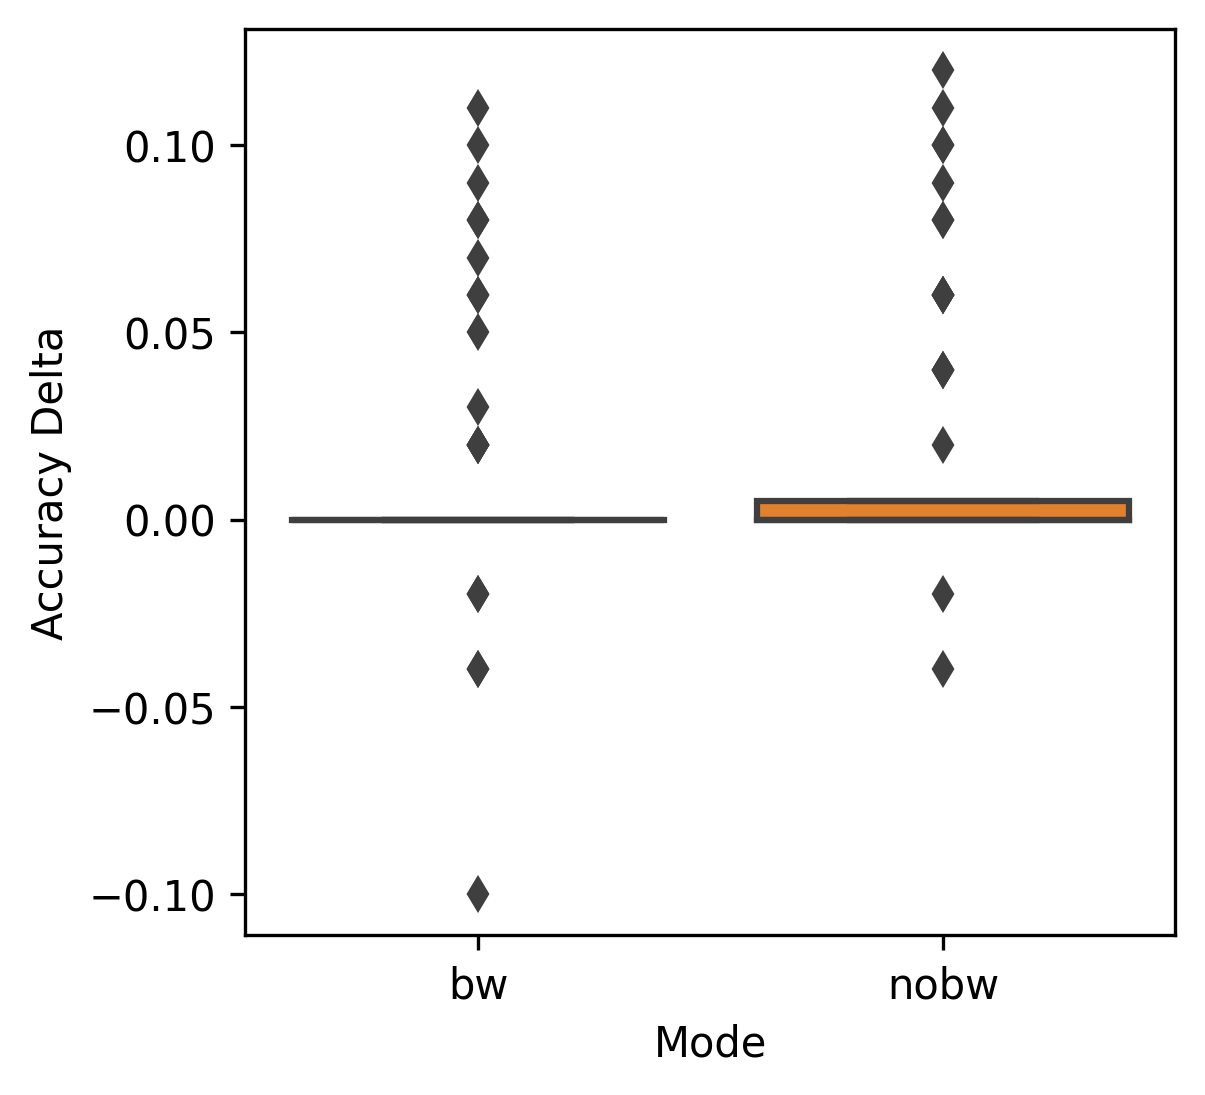

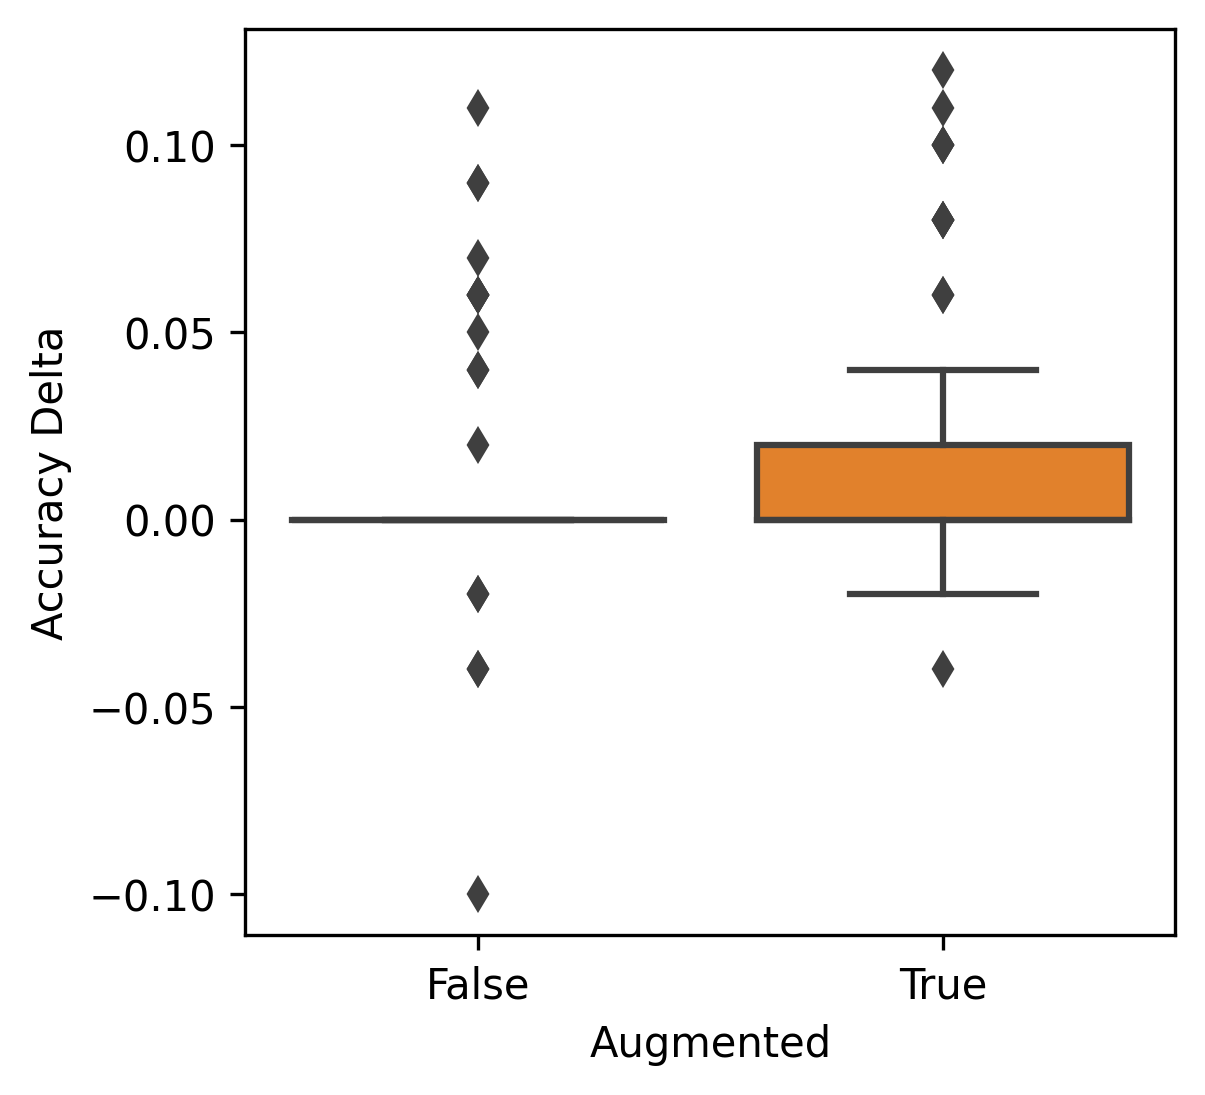

STD 0.03454779906402219,
Median 0.0,
Mean 0.013250000000000029,
Runs 120


In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


SORT_ORDER = ["Mode", "MSS", "Score", "Augmented"]

def get_metric(metric="Accuracy"):

    df_colorized = df[df["Colorized"] == True].sort_values(by=SORT_ORDER)[metric].astype(float)
    df_microfilm = df[df["Colorized"] == False].sort_values(by=SORT_ORDER)[metric].astype(float)

    accuracy_final = list(df_colorized.to_numpy() - df_microfilm.to_numpy())
    recomposed_df = pandas.DataFrame([
        {"Accuracy Delta": a, "Mode": r.Mode, "MSS": r.MSS, "Augmented": r.Augmented}
        for a, (_, r) in zip(accuracy_final, df[df["Colorized"] == False].sort_values(
            by=SORT_ORDER).iterrows())
        ])

    fig, ax = plt.subplots(figsize=(4,4), dpi=300)
    sns.boxplot(y="Accuracy Delta", data=recomposed_df, ax=ax)
    plt.show()


    fig, ax = plt.subplots(figsize=(4,4), dpi=300)
    sns.boxplot(y="Accuracy Delta", x="MSS", data=recomposed_df, ax=ax)
    plt.show()

    fig, ax = plt.subplots(figsize=(4,4), dpi=300)
    sns.boxplot(y="Accuracy Delta", x="Mode", data=recomposed_df, ax=ax)
    plt.show()

    fig, ax = plt.subplots(figsize=(4,4), dpi=300)
    sns.boxplot(y="Accuracy Delta", x="Augmented", data=recomposed_df, ax=ax)
    plt.show()

    print(f"STD {recomposed_df['Accuracy Delta'].std()},\n"
          f"Median {recomposed_df['Accuracy Delta'].median()},\n"
          f"Mean {recomposed_df['Accuracy Delta'].mean()},\n"
          f"Runs {len(recomposed_df)}")
    
get_metric()

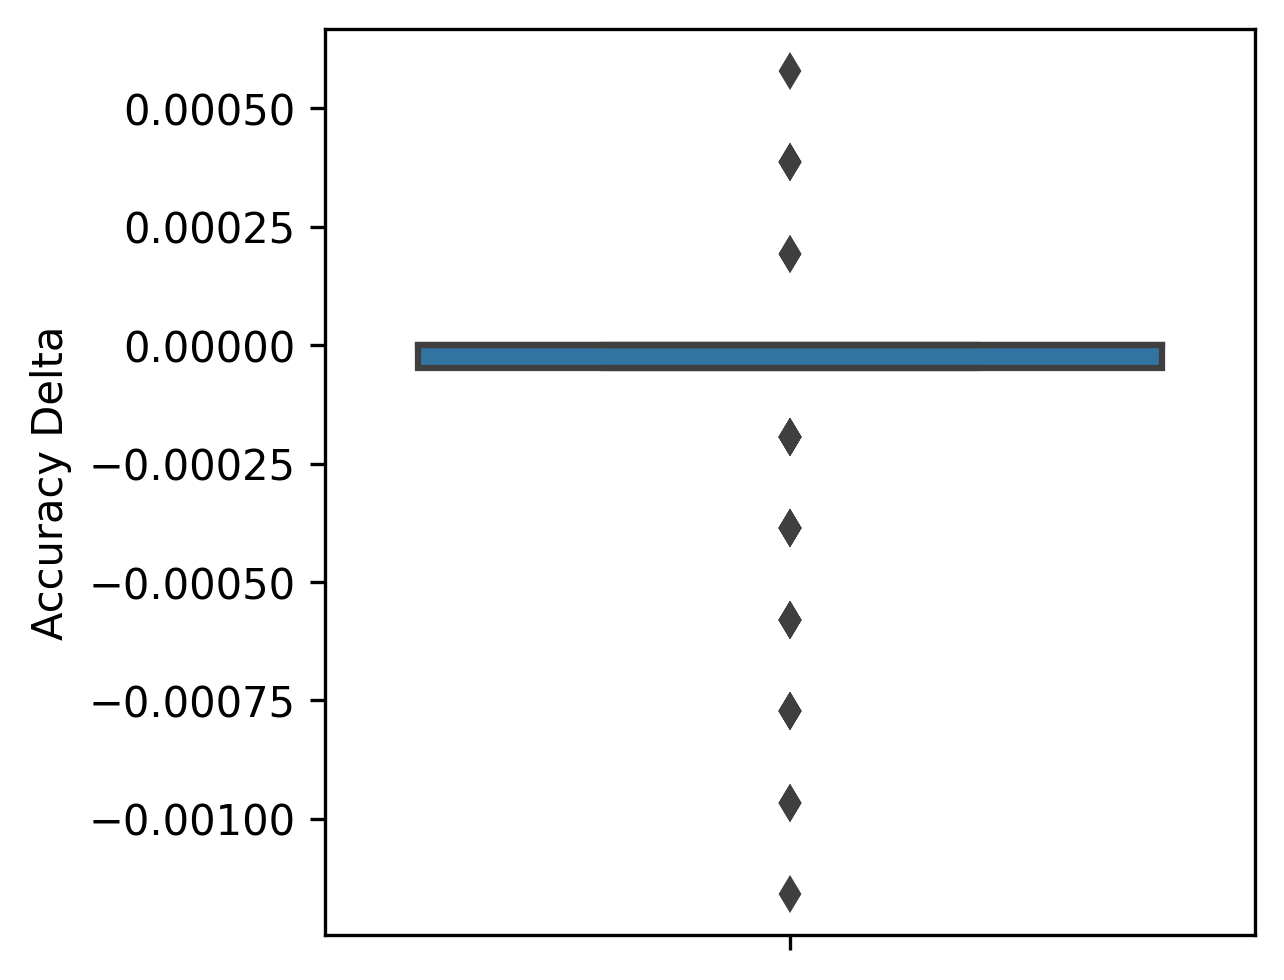

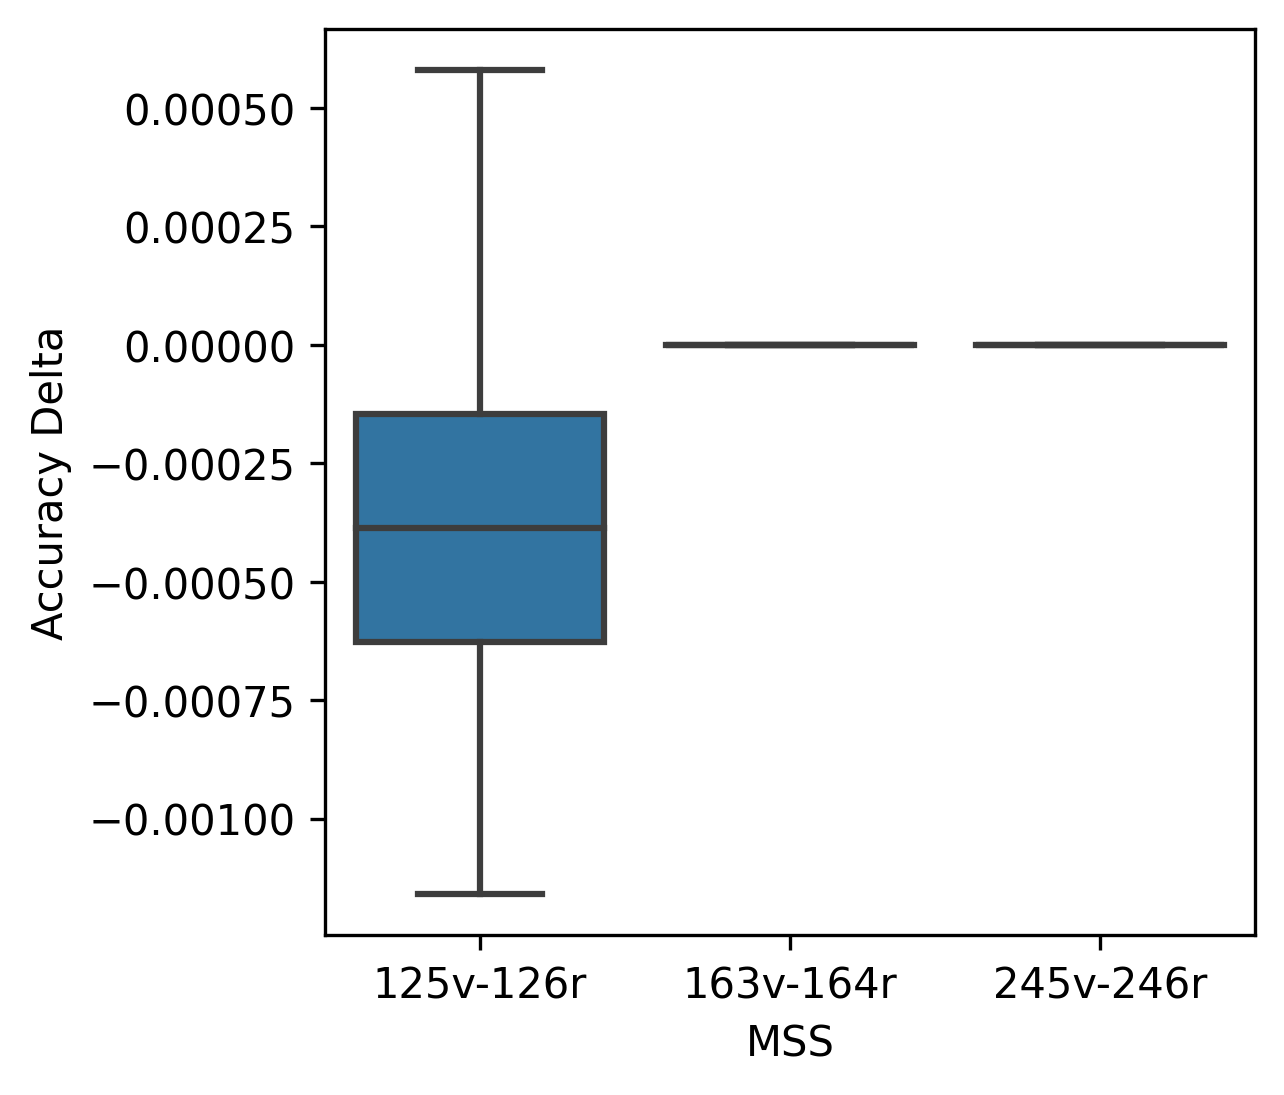

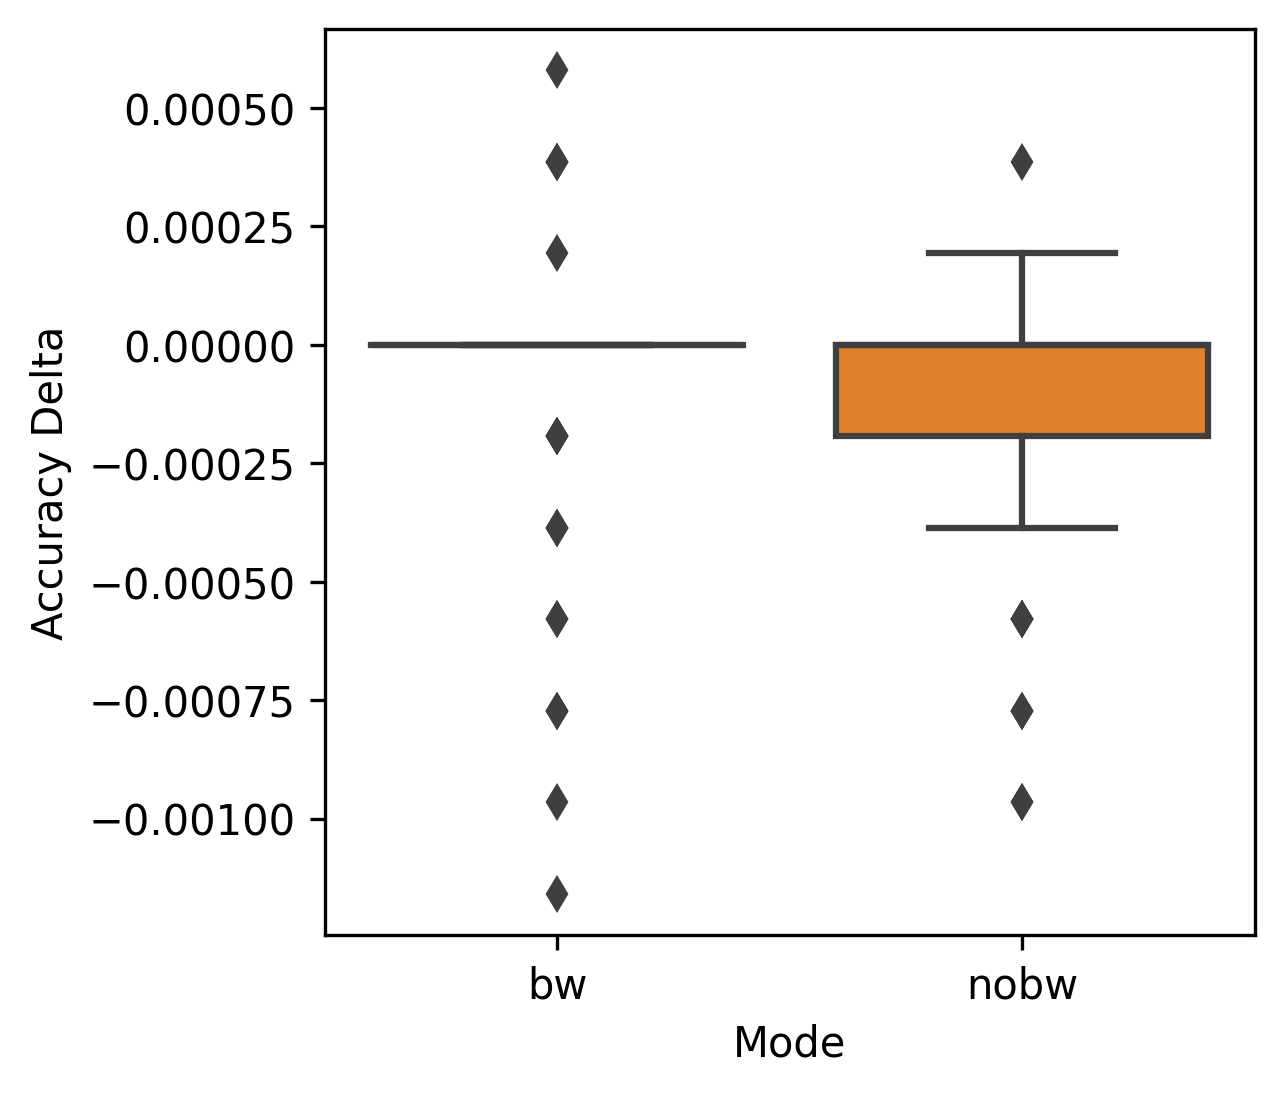

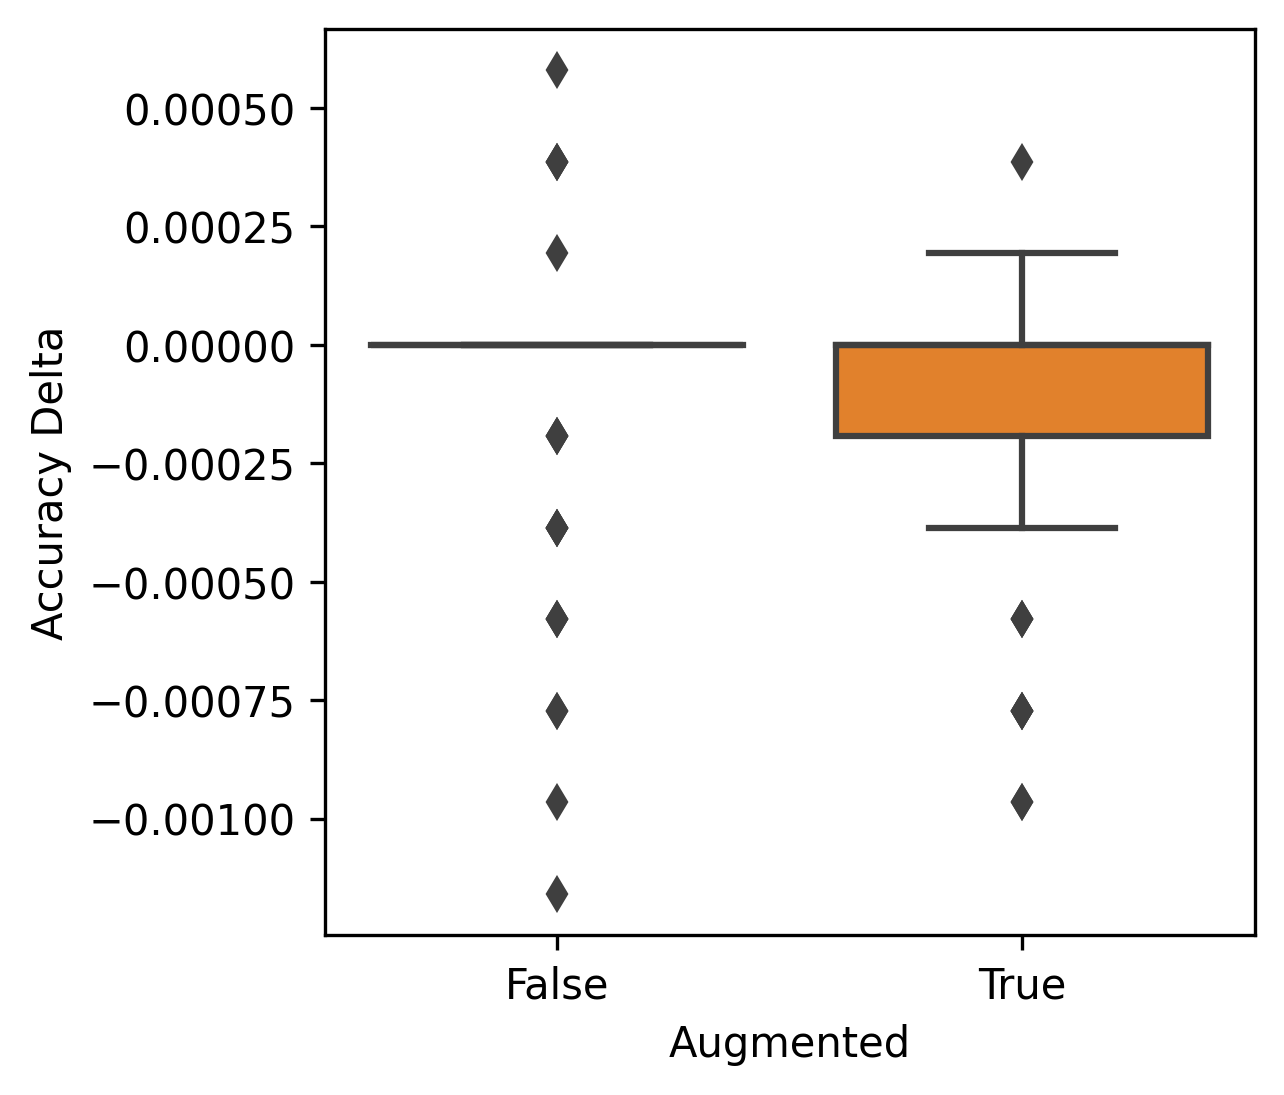

STD 0.00029687865363063165,
Median 0.0,
Mean -0.00011430963420916985,
Runs 120


In [37]:

get_metric("NonSpaceAccuracy")